In [1]:
# Libs
import xarray as xr
import matplotlib.pyplot as plt

# Locals
import oggm.cfg as cfg
from oggm import utils, workflow, tasks
from oggm.core import gcm_climate

In [2]:

# Initialize OGGM and set up the default run parameters
cfg.initialize(logging_level='WORKFLOW')
rgi_version = '62'

# Here we override some of the default parameters
# How many grid points around the glacier?
# Make it large if you expect your glaciers to grow large:
# here, 80 is more than enough
cfg.PARAMS['border'] = 80

# Local working directory (where OGGM will write its output)
WORKING_DIR = utils.gettempdir('OGGM_plot_run')
utils.mkdir(WORKING_DIR, reset=True)
cfg.PATHS['working_dir'] = WORKING_DIR

# RGI glaciers: Artesonraju and Shallap in Peru
rgi_ids = utils.get_rgi_glacier_entities(['RGI60-16.02444', 'RGI60-16.02207'])

# Go - get the pre-processed glacier directories
gdirs = workflow.init_glacier_directories(rgi_ids, from_prepro_level=3)

# Initialise glacier for run
workflow.execute_entity_task(tasks.init_present_time_glacier, gdirs);

2020-10-21 09:54:06: oggm.cfg: Reading default parameters from the OGGM `params.cfg` configuration file.
2020-10-21 09:54:06: oggm.cfg: Multiprocessing switched ON according to the parameter file.
2020-10-21 09:54:06: oggm.cfg: Multiprocessing: using all available processors (N=4)
2020-10-21 09:54:07: oggm.cfg: PARAMS['border'] changed from `20` to `80`.
2020-10-21 09:54:08: oggm.workflow: init_glacier_directories from prepro level 3 on 2 glaciers.
2020-10-21 09:54:08: oggm.workflow: Execute entity task gdir_from_prepro on 2 glaciers
2020-10-21 09:54:32: oggm.workflow: Execute entity task init_present_time_glacier on 2 glaciers


In [3]:
gdirs[0].rgi_date, gdirs[1].rgi_date

(2008, 2003)

In [4]:
workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, 
                             ye=2017, # end year (start is automatically recognized from glacier attributes)
                             output_filesuffix='_spinup',  # to use the files as input later on
                            );

2020-10-21 09:54:32: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers


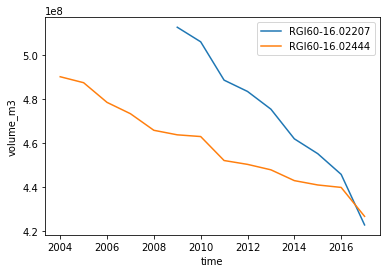

In [5]:

for gdir in gdirs:
    ds = xr.open_dataset(gdir.get_filepath('model_diagnostics', filesuffix='_spinup'))
    ds.volume_m3.plot(label=gdir.rgi_id)
plt.legend();

In [6]:

bp = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/pr/pr_mon_CCSM4_{}_r1i1p1_g025.nc'
bt = 'https://cluster.klima.uni-bremen.de/~oggm/cmip5-ng/tas/tas_mon_CCSM4_{}_r1i1p1_g025.nc'
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    # Download the files
    ft = utils.file_downloader(bt.format(rcp))
    fp = utils.file_downloader(bp.format(rcp))
    # bias correct them
    workflow.execute_entity_task(gcm_climate.process_cmip5_data, gdirs, 
                                 filesuffix='_CCSM4_{}'.format(rcp),  # recognize the climate file for later
                                 fpath_temp=ft,  # temperature projections
                                 fpath_precip=fp,  # precip projections
                                 );

2020-10-21 09:55:18: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers
2020-10-21 09:55:58: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers
2020-10-21 09:56:33: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers
2020-10-21 09:57:04: oggm.workflow: Execute entity task process_cmip5_data on 2 glaciers


In [7]:
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    workflow.execute_entity_task(tasks.run_from_climate_data, gdirs, ys=2017, ye=2100, 
                                 climate_filename='gcm_data',  # use gcm_data, not climate_historical
                                 climate_input_filesuffix=rid,  # use a different scenario
                                 init_model_filesuffix='_spinup',  # this is important! Start from 2016 glacier
                                 output_filesuffix=rid,  # recognize the run for later
                                );

2020-10-21 09:57:05: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2020-10-21 09:57:08: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2020-10-21 09:57:11: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers
2020-10-21 09:57:14: oggm.workflow: Execute entity task run_from_climate_data on 2 glaciers


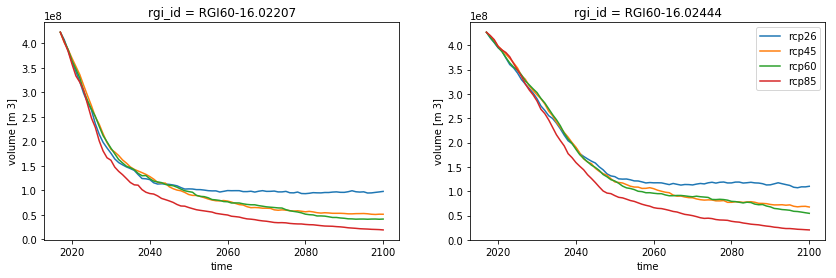

In [8]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 4))
for rcp in ['rcp26', 'rcp45', 'rcp60', 'rcp85']:
    rid = '_CCSM4_{}'.format(rcp)
    ds = utils.compile_run_output(gdirs, input_filesuffix=rid)
    ds.isel(rgi_id=0).volume.plot(ax=ax1, label=rcp);
    ds.isel(rgi_id=1).volume.plot(ax=ax2, label=rcp);
plt.legend();